In [5]:
import sys
sys.path.append('..') # Add parent directory to path

import pandas as pd
import glob
import os
import requests
import time
import datetime
import matplotlib.pyplot as plt
from weather.src.config import locations

In [7]:
weather_files = glob.glob(
    os.path.join('ds', "*_weather.csv")
)

weather_data = pd.DataFrame()
for ind, file in enumerate(weather_files):
    df = pd.read_csv(file)
    df["resort"] = os.path.basename(file).split("_")[0]
    weather_data = pd.concat([weather_data, df])

weather_data.head()

,date,temperature_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_100m,is_day,sunshine_duration,fetch_timestamp,request_file,resort
0,2024-02-01 00:00:00+00:00,-0.5195,-3.535757,0.0,0.0,0.0,1.37,0.000000,0.0,0.0,0.0,3.758510,0.0,0.0,2024-03-30 10:56:20.684646,laax_2024-03-30T10:56:20.684646.csv,laax
1,2024-02-01 01:00:00+00:00,-1.1695,-4.503199,0.0,0.0,0.0,1.37,5.100000,0.0,0.0,17.0,7.091177,0.0,0.0,2024-03-30 10:56:20.684646,laax_2024-03-30T10:56:20.684646.csv,laax
2,2024-02-01 02:00:00+00:00,-1.0695,-4.452381,0.0,0.0,0.0,1.37,22.500000,1.0,0.0,72.0,7.993297,0.0,0.0,2024-03-30 10:56:20.684646,laax_2024-03-30T10:56:20.684646.csv,laax
3,2024-02-01 03:00:00+00:00,-1.2195,-4.383105,0.0,0.0,0.0,1.37,30.900000,2.0,0.0,97.0,4.198285,0.0,0.0,2024-03-30 10:56:20.684646,laax_2024-03-30T10:56:20.684646.csv,laax
4,2024-02-01 04:00:00+00:00,-1.6195,-4.924282,0.0,0.0,0.0,1.37,31.800001,2.0,0.0,100.0,5.447788,0.0,0.0,2024-03-30 10:56:20.684646,laax_2024-03-30T10:56:20.684646.csv,laax


In [6]:
price_files = glob.glob(
    os.path.join('ds', "*_prices.csv")
)

price_data = pd.DataFrame()
for ind, file in enumerate(price_files):
    df = pd.read_csv(file)
    df["resort"] = os.path.basename(file).split("_")[0]
    price_data = pd.concat([price_data, df])

price_data["day"] = pd.to_datetime(price_data["date"]).apply(lambda x: x.date())
price_data.tail()

,date,price,fetch_timestamp,scrape_file,resort,day
67375,2024-04-07,61.0,2024-03-30 10:45:50.753235,adelboden_2024-03-30T10:45:50.753235.csv,adelboden,2024-04-07
67376,2024-04-07,61.0,2024-03-30 11:00:52.251340,adelboden_2024-03-30T11:00:52.251340.csv,adelboden,2024-04-07
67377,2024-04-07,61.0,2024-03-30 11:00:52.251340,adelboden_2024-03-30T11:00:52.251340.csv,adelboden,2024-04-07
67378,2024-04-07,61.0,2024-03-30 11:15:52.953049,adelboden_2024-03-30T11:15:52.953049.csv,adelboden,2024-04-07
67379,2024-04-07,61.0,2024-03-30 11:15:52.953049,adelboden_2024-03-30T11:15:52.953049.csv,adelboden,2024-04-07


In [8]:
print(price_data[(price_data["resort"] == "adelboden") & (price_data["day"] == datetime.datetime.strptime("2024-04-07", '%Y-%m-%d').date())]["price"].max())

61.0


### Augmentation
- add daylight duration
- add sunnyness (percentage of sunny hours of daylight hours)

In [9]:
def calc_features(group):
    resort = group["resort"].iloc[0]
    day = pd.to_datetime(group["date"].iloc[0]).date()
    lat = [location["latitude"] for location in locations if location["short_name"] == resort][0]
    long = [location["longitude"] for location in locations if location["short_name"] == resort][0]
    date = group["date"].iloc[0]
    response = requests.get(f"https://api.sunrisesunset.io/json?lat={lat}&lng={long}&date={date}").json()
    tt = time.strptime(response["results"]["day_length"],'%H:%M:%S')
    daylight_seconds = datetime.timedelta(hours=tt.tm_hour,minutes=tt.tm_min,seconds=tt.tm_sec).total_seconds()

    d = {}
    #d["max_temp"] = group["temperature_2m"].max()
    #d["min_temp"] = group["temperature_2m"].min()
    d["avg_temp"] = group["temperature_2m"].mean()
    #d["avg_temp2"] = (group["temperature_2m"].max() + group["temperature_2m"].min()) / 2
    #d["max_wind"] = group["wind_speed_100m"].max()
    #d["min_wind"] = group["wind_speed_100m"].min()
    d["avg_wind"] = group["wind_speed_100m"].mean()
    d["avg_percipitation"] = group["precipitation"].mean()
    d["sum_snow"] = group["snowfall"].sum()

    d["day_hours"] = daylight_seconds / 3600
    d["sunnyness"] = group[group['is_day'] > 0]["sunshine_duration"].sum() / daylight_seconds

    d["max_price"] = price_data[(price_data["resort"] == resort) & (price_data["day"] == day)]["price"].max()
    return pd.Series(d)

aug_data = {}
for ind, (key, item) in enumerate(weather_data.groupby("resort")):
    item["day"] = pd.to_datetime(item["date"]).apply(lambda x: x.date())
    by_day = item.groupby("day").apply(calc_features, include_groups=False)
    aug_data[key] = by_day

In [11]:
for index, resort in enumerate(aug_data):
    aug_data[resort].to_csv(f"ds/{resort}_augmented.csv")

In [16]:
augmented_files = glob.glob(
    os.path.join('ds', "*_augmented.csv")
)

augmented_data = {}
for ind, file in enumerate(augmented_files):
    result = os.path.basename(file).split("_")[0]
    augmented_data[resort] = pd.read_csv(file)

In [ ]:
# TODO: add price increase steepness as feature

/tmp/ipykernel_195540/485727448.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


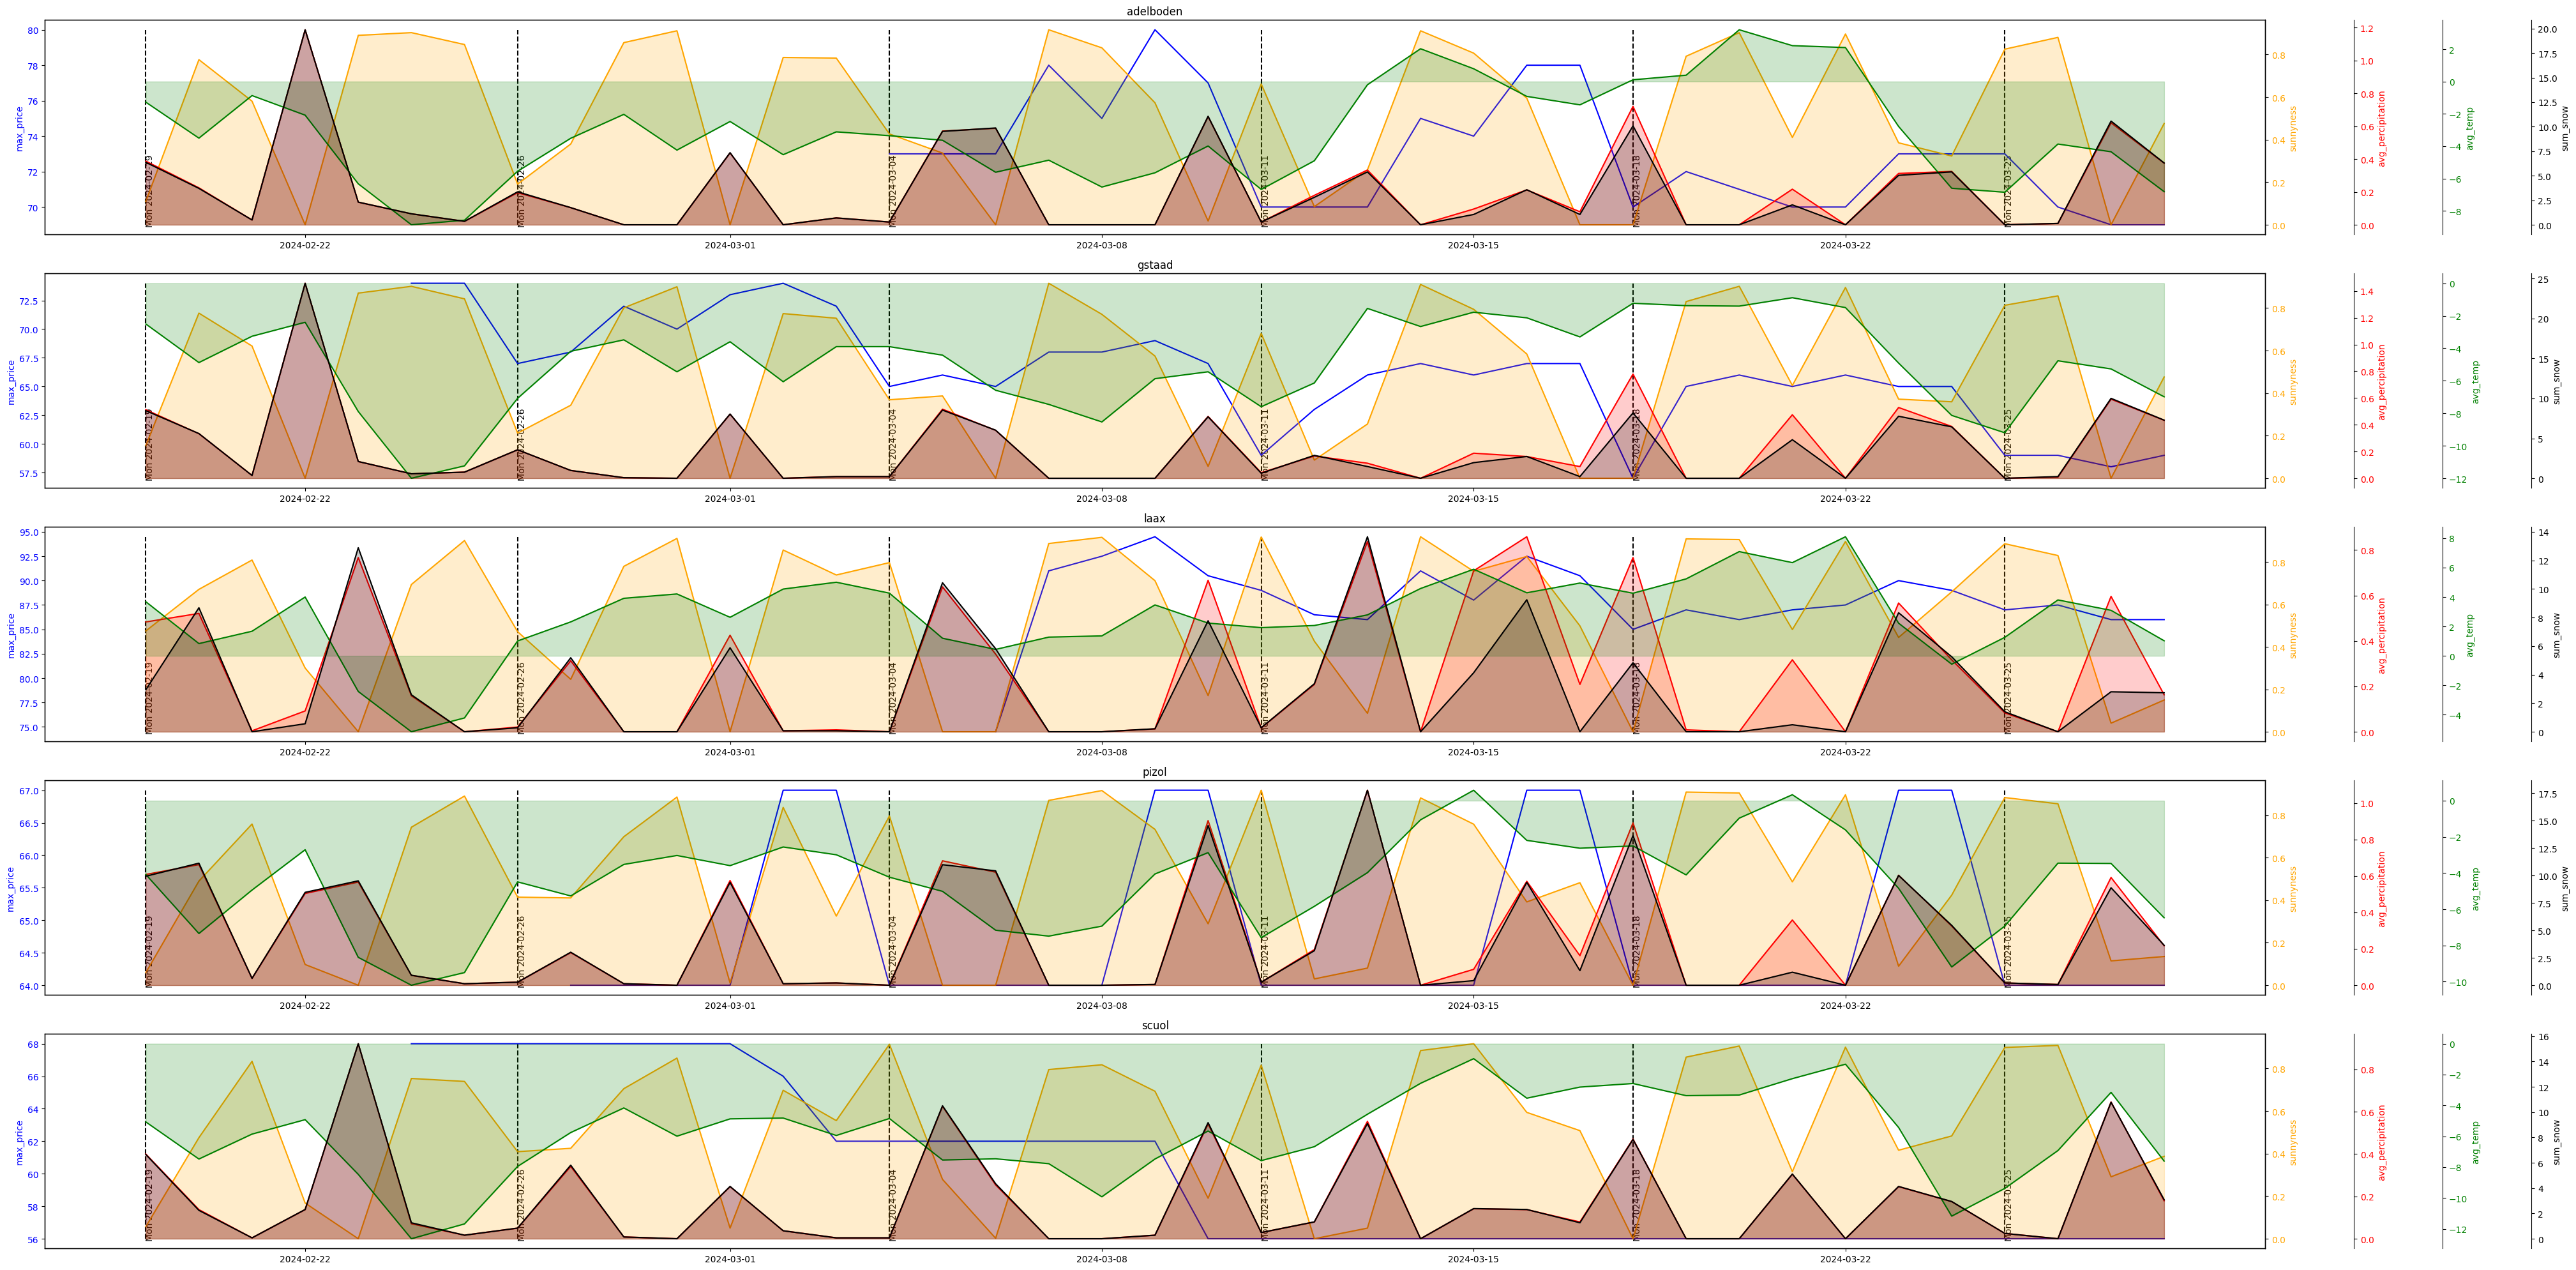

In [15]:
def get_mondays(start, end):
    start = start - datetime.timedelta(days=start.weekday())
    end = end - datetime.timedelta(days=end.weekday())
    current = start
    while current <= end:
        yield current
        current = current + datetime.timedelta(days=7)

fig = plt.figure(figsize=(40, 20))
for index, resort in enumerate(aug_data):
    axis = fig.add_subplot(
        5,1,index+1,
        yticks=[],
        title=resort
    )
    df = aug_data[resort]
    df = df[df.index >= datetime.datetime.strptime("2024-02-19", '%Y-%m-%d').date()]
    
    for monday in get_mondays(df.index.min(), df.index.max()):
        axis.vlines(monday, 0, 1, color='black', linestyle='--')
        axis.text(monday,0, monday.strftime('%a %Y-%m-%d') ,rotation=90)

    for index, (col, color) in enumerate([
        ('max_price', 'blue'),
        ('sunnyness', 'orange'),
        ('avg_percipitation', 'red'),
        ('avg_temp', 'green'),
        ('sum_snow', 'black'),
    ]):
        ax = axis.twinx()
        if index > 0:
            ax.plot(df.index, df[col], color=color)
            ax.fill_between(df.index, df[col], color=color, alpha=.2)
            ax.set_yticks([])
            sax = ax.secondary_yaxis(1.0 + 0.04 * (index - 1))
            sax.set_ylabel(col, color=color)
            sax.tick_params(axis='y', labelcolor=color)
        else:
            ax.plot(df.index, df[col], color=color)
            ax.yaxis.set_ticks_position("left")
            ax.yaxis.set_label_position("left")
            ax.set_ylabel(col, color=color)
            ax.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.show()